<a href="https://colab.research.google.com/github/fathurrahmanyahyasatrio/Credit-Card-Fraud-Detection/blob/main/Credit%20Card%20Fraud%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Credit Card Fraud Detection**

**Business Understanding**

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
pip install imbalanced-learn


In [1]:
pip install catboost


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

In [3]:
data_df = pd.read_csv("creditcard.csv")

In [4]:
print("Credit Card Fraud Detection data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Credit Card Fraud Detection data -  rows: 284807  columns: 31


**Looking at the features of the data**

In [5]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


By examining the Time feature, we can verify that the dataset comprises 284,807 transactions that occurred over a span of two consecutive days, equivalent to 172,792 seconds

Check missing data


In [7]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V16,Amount,V28,V27,V26,V25,V24,V23,V22,V21,V20,V19,V18,V17,V15,V1,V14,V13,V12,V11,V10,V9,V8,V7,V6,V5,V4,V3,V2,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Unbalanced Data**

In [8]:
import plotly.graph_objs as go
from plotly.offline import iplot


In [9]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)


In [10]:
import pandas as pd


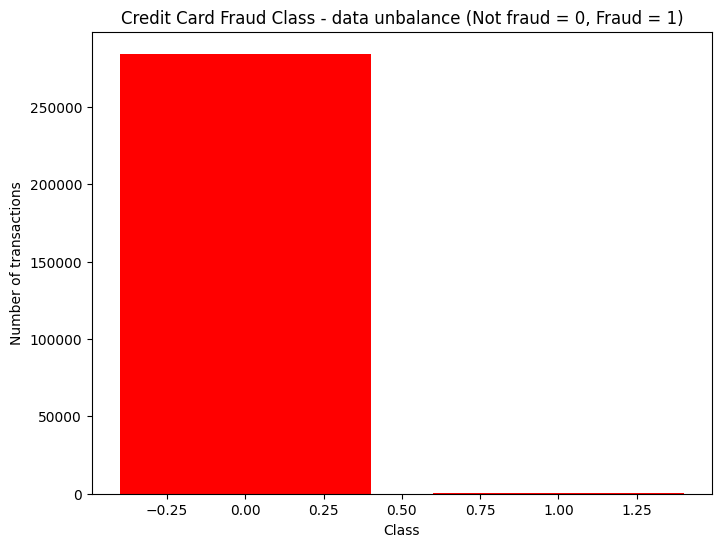

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

temp = data_df["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index, 'values': temp.values})

plt.figure(figsize=(8, 6))
plt.bar(df['Class'], df['values'], color="red")
plt.title('Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)')
plt.xlabel('Class')
plt.ylabel('Number of transactions')
plt.show()


Merely 492 transactions, equivalent to a mere 0.172%, are characterized as fraudulent. This indicates a significant imbalance in the dataset concerning the target variable "Class."

**Imbalanced Data**

SMOTE

In [12]:
data_df = pd.DataFrame({
    "Class": np.random.choice([0, 1], size=1000, p=[0.95, 0.05])  # Replace with your actual data
})


In [13]:
# Remove this part
data_df = pd.DataFrame({
    "Class": np.random.choice([0, 1], size=1000, p=[0.95, 0.05])  # Replace with your actual data
})


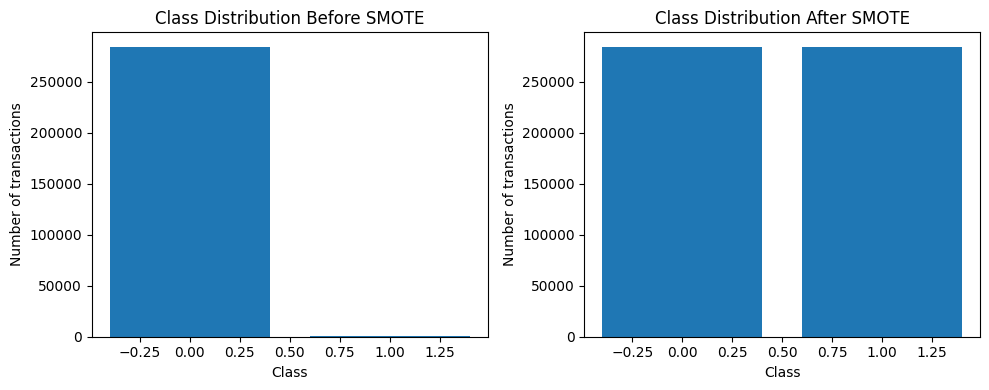

In [14]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load your actual credit card fraud dataset (replace "creditcard.csv" with your actual file path)
data_df = pd.read_csv("creditcard.csv")

# Ensure that the "Class" column is of integer type
data_df["Class"] = data_df["Class"].astype(int)

# Separate features (X) and target variable (y)
X = data_df.drop(columns=["Class"])  # Features
y = data_df["Class"]  # Target variable

# Oversample the minority class (Class 1) using SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)  # You can specify a random_state for reproducibility
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the class distribution before and after SMOTE
class_distribution_before = data_df["Class"].value_counts()
class_distribution_after = pd.Series(y_resampled).value_counts()

# Plot class distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(class_distribution_before.index, class_distribution_before.values)
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Number of transactions")

plt.subplot(1, 2, 2)
plt.bar(class_distribution_after.index, class_distribution_after.values)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Number of transactions")

plt.tight_layout()
plt.show()


ADASYN

In [15]:
pip install imbalanced-learn


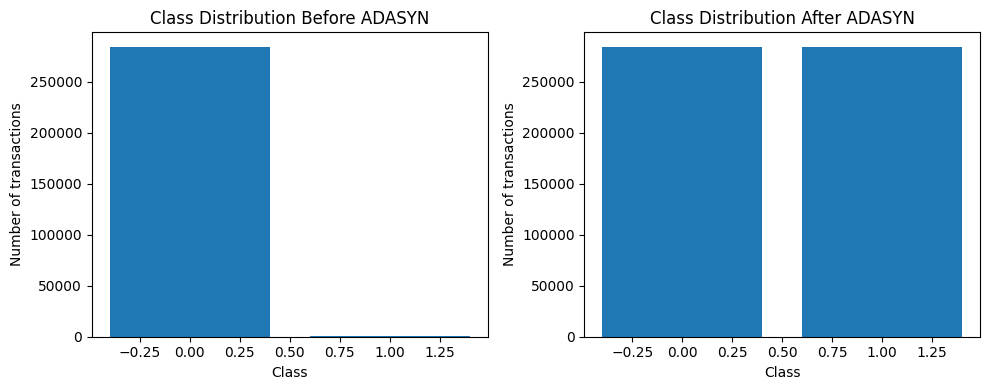

In [16]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt

# Load your actual credit card fraud dataset (replace "creditcard.csv" with your actual file path)
data_df = pd.read_csv("creditcard.csv")

# Ensure that the "Class" column is of integer type
data_df["Class"] = data_df["Class"].astype(int)

# Separate features (X) and target variable (y)
X = data_df.drop(columns=["Class"])  # Features
y = data_df["Class"]  # Target variable

# Oversample the minority class (Class 1) using ADASYN
adasyn = ADASYN(sampling_strategy='minority', random_state=42)  # You can specify a random_state for reproducibility
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Check the class distribution before and after ADASYN
class_distribution_before = data_df["Class"].value_counts()
class_distribution_after = pd.Series(y_resampled).value_counts()

# Plot class distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(class_distribution_before.index, class_distribution_before.values)
plt.title("Class Distribution Before ADASYN")
plt.xlabel("Class")
plt.ylabel("Number of transactions")

plt.subplot(1, 2, 2)
plt.bar(class_distribution_after.index, class_distribution_after.values)
plt.title("Class Distribution After ADASYN")
plt.xlabel("Class")
plt.ylabel("Number of transactions")

plt.tight_layout()
plt.show()


MWOTE

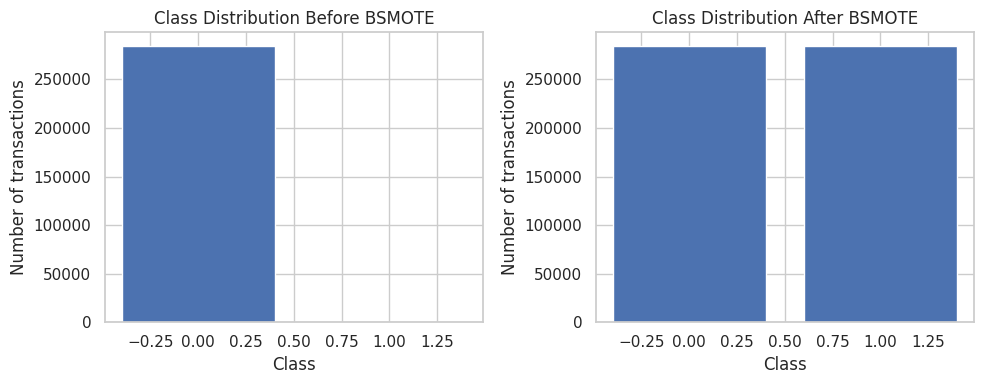

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import BorderlineSMOTE  # Change mwote to bsmote
from sklearn.datasets import make_classification

# Load your actual credit card fraud dataset (replace "creditcard.csv" with your actual file path)
data_df = pd.read_csv("creditcard.csv")

# Ensure that the "Class" column is of integer type
data_df["Class"] = data_df["Class"].astype(int)

# Separate features (X) and target variable (y)
X = data_df.drop(columns=["Class"])  # Features
y = data_df["Class"]  # Target variable

# Choose the BorderlineSMOTE technique (BSMOTE)
bsmote = BorderlineSMOTE(sampling_strategy='minority', random_state=42)  # You can specify a random_state for reproducibility
X_resampled, y_resampled = bsmote.fit_resample(X, y)

# Check the class distribution before and after BSMOTE
class_distribution_before = data_df["Class"].value_counts()
class_distribution_after = pd.Series(y_resampled).value_counts()

# Plot class distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(class_distribution_before.index, class_distribution_before.values)
plt.title("Class Distribution Before BSMOTE")
plt.xlabel("Class")
plt.ylabel("Number of transactions")

plt.subplot(1, 2, 2)
plt.bar(class_distribution_after.index, class_distribution_after.values)
plt.title("Class Distribution After BSMOTE")
plt.xlabel("Class")
plt.ylabel("Number of transactions")

plt.tight_layout()
plt.show()


In [63]:
X_resampled

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.620000
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000
2,1.000000,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660000
3,1.000000,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000
4,2.000000,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.990000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568625,28672.058755,-28.803809,15.992205,-29.694078,6.459639,-20.967865,-4.881066,-19.621060,18.922312,-3.632343,-7.910896,4.135709,-5.763300,1.247795,-5.226648,-0.121894,-5.316789,-11.366928,-4.689281,0.675372,1.710588,1.807255,-2.142713,-1.337164,0.171683,2.073262,-0.210271,1.292206,0.376997,99.990000
568626,8621.626440,-0.332802,3.348048,-6.172791,4.963260,-1.821721,-2.433839,-4.294671,1.399770,-1.544836,-5.889185,6.615675,-8.881742,0.414758,-8.024371,-0.043557,-4.051228,-5.365624,-0.911085,1.308795,0.512762,0.745766,-0.013669,0.386149,0.021545,-1.144568,0.358648,0.660820,0.210142,1.000000
568627,143335.920750,-2.068571,2.910489,-3.464342,4.574243,0.070072,-1.193859,-2.465427,1.443642,-3.223653,-4.283298,2.771887,-4.713478,-0.973684,-7.315797,-2.341658,-1.671077,-4.690787,-1.027495,-1.544218,0.075334,0.598477,-0.161996,-0.387654,-0.283188,0.254505,-0.005080,0.427033,0.131451,0.792644
568628,154346.833424,-3.451137,-4.756229,-5.894864,3.401010,0.886739,-2.907860,-1.671024,0.433235,-0.706554,-4.309466,2.811372,-3.646433,-2.066940,-5.994460,-0.717161,-1.553270,-2.028024,0.428286,0.100458,3.107204,1.186501,-0.970839,-1.084007,-0.627958,-0.080415,0.401751,0.329662,-0.068976,1034.323885


In [64]:
y_resampled

0         0
1         0
2         0
3         0
4         0
         ..
568625    1
568626    1
568627    1
568628    1
568629    1
Name: Class, Length: 568630, dtype: int64

In [65]:
data_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


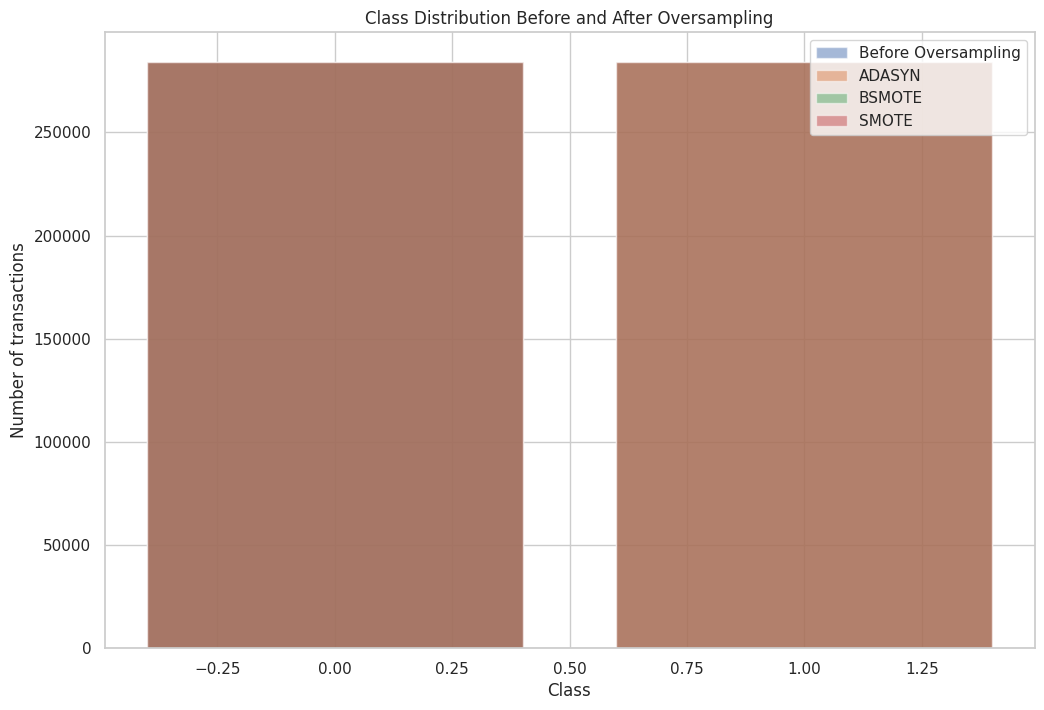

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, SMOTENC
from sklearn.datasets import make_classification

# Load your actual credit card fraud dataset (replace "creditcard.csv" with your actual file path)
data_df = pd.read_csv("creditcard.csv")

# Ensure that the "Class" column is of integer type
data_df["Class"] = data_df["Class"].astype(int)

# Separate features (X) and target variable (y)
X = data_df.drop(columns=["Class"])  # Features
y = data_df["Class"]  # Target variable

# Calculate the class distribution before oversampling
class_distribution_before = y.value_counts()

# Apply ADASYN
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X, y)
class_distribution_adasyn = pd.Series(y_resampled_adasyn).value_counts()

# Apply BSMOTE (using BorderlineSMOTE as an example)
bsmote = BorderlineSMOTE(sampling_strategy='minority', random_state=42)
X_resampled_bsmote, y_resampled_bsmote = bsmote.fit_resample(X, y)
class_distribution_bsmote = pd.Series(y_resampled_bsmote).value_counts()

# Apply SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)
class_distribution_smote = pd.Series(y_resampled_smote).value_counts()

# Plot class distribution before and after oversampling
plt.figure(figsize=(12, 8))
plt.bar(class_distribution_before.index, class_distribution_before.values, label='Before Oversampling', alpha=0.5)
plt.bar(class_distribution_adasyn.index, class_distribution_adasyn.values, label='ADASYN', alpha=0.5)
plt.bar(class_distribution_mwote.index, class_distribution_mwote.values, label='BSMOTE', alpha=0.5)
plt.bar(class_distribution_smote.index, class_distribution_smote.values, label='SMOTE', alpha=0.5)
plt.title('Class Distribution Before and After Oversampling')
plt.xlabel('Class')
plt.ylabel('Number of transactions')
plt.legend()
plt.show()


In [68]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, SMOTENC
from sklearn.datasets import make_classification

# Load your actual credit card fraud dataset (replace "creditcard.csv" with your actual file path)
data_df = pd.read_csv("creditcard.csv")

# Ensure that the "Class" column is of integer type
data_df["Class"] = data_df["Class"].astype(int)

# Separate features (X) and target variable (y)
X = data_df.drop(columns=["Class"])  # Features
y = data_df["Class"]  # Target variable

# Calculate the imbalanced ratio before oversampling
imbalanced_ratio_before = (y.value_counts()[1]) / (y.value_counts()[0])

# Apply ADASYN
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X, y)
imbalanced_ratio_adasyn = (pd.Series(y_resampled_adasyn).value_counts()[1]) / (pd.Series(y_resampled_adasyn).value_counts()[0])

# Apply BSMOTE (using BorderlineSMOTE as an example)
bsmote = BorderlineSMOTE(sampling_strategy='minority', random_state=42)
X_resampled_bsmote, y_resampled_bsmote = bsmote.fit_resample(X, y)
imbalanced_ratio_bsmote = (pd.Series(y_resampled_bsmote).value_counts()[1]) / (pd.Series(y_resampled_bsmote).value_counts()[0])

# Apply SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)
imbalanced_ratio_smote = (pd.Series(y_resampled_smote).value_counts()[1]) / (pd.Series(y_resampled_smote).value_counts()[0])

# Print the imbalanced ratios
print("Imbalanced Ratio Before Oversampling:", imbalanced_ratio_before)
print("Imbalanced Ratio After ADASYN:", imbalanced_ratio_adasyn)
print("Imbalanced Ratio After BSMOTE:", imbalanced_ratio_bsmote)
print("Imbalanced Ratio After SMOTE:", imbalanced_ratio_smote)


Imbalanced Ratio Before Oversampling: 0.0017304750013189597
Imbalanced Ratio After ADASYN: 0.9999402071645885
Imbalanced Ratio After BSMOTE: 1.0
Imbalanced Ratio After SMOTE: 1.0


In [69]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import BorderlineSMOTE

# Load your actual credit card fraud dataset (replace "creditcard.csv" with your actual file path)
data_df = pd.read_csv("creditcard.csv")

# Ensure that the "Class" column is of integer type
data_df["Class"] = data_df["Class"].astype(int)

# Separate features (X) and target variable (y)
X = data_df.drop(columns=["Class"])  # Features
y = data_df["Class"]  # Target variable

# Choose the MWMOTE technique (BSMOTE in this example)
bsmote = BorderlineSMOTE(sampling_strategy='minority', random_state=42)  # You can specify a random_state for reproducibility
X_resampled, y_resampled = bsmote.fit_resample(X, y)

# Create a new DataFrame (Data_MWOTE) by combining the resampled X and y with the original data
Data_BSMOTE = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name="Class")], axis=1)

# Now, Data_BSMOTE contains the resampled data along with the original data


**Exploratory Data Analysis**

Transactions in time

<ipython-input-17-cb33e0569e55>:15: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-17-cb33e0569e55>:16: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




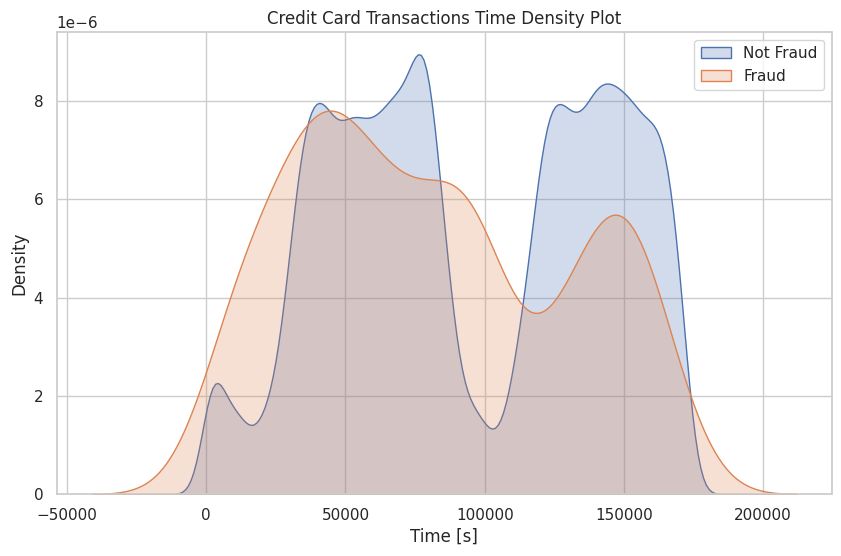

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already loaded your dataset and separated it into X and y
# X = data_df.drop(columns=["Class"])  # Features
# y = data_df["Class"]  # Target variable

# Extract the "Time" feature for fraud and not fraud transactions
class_0 = X[y == 0]["Time"]
class_1 = X[y == 1]["Time"]

# Create density plots
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.kdeplot(class_0, label="Not Fraud", shade=True)
sns.kdeplot(class_1, label="Fraud", shade=True)

# Set plot labels and title
plt.xlabel("Time [s]")
plt.ylabel("Density")
plt.title("Credit Card Transactions Time Density Plot")

# Show legend
plt.legend()

# Show the plot
plt.show()


Fraudulent transactions exhibit a smoother distribution compared to legitimate transactions, showing an even distribution across time, including the lower transaction times, particularly during nighttime in the European timezone.

Now, let's delve deeper into the time distribution of transactions for both classes, as well as examine aggregated values for transaction count and amount per hour. We make this assumption based on our observation of the transaction time distribution, considering the time unit to be in seconds.

In [18]:
data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


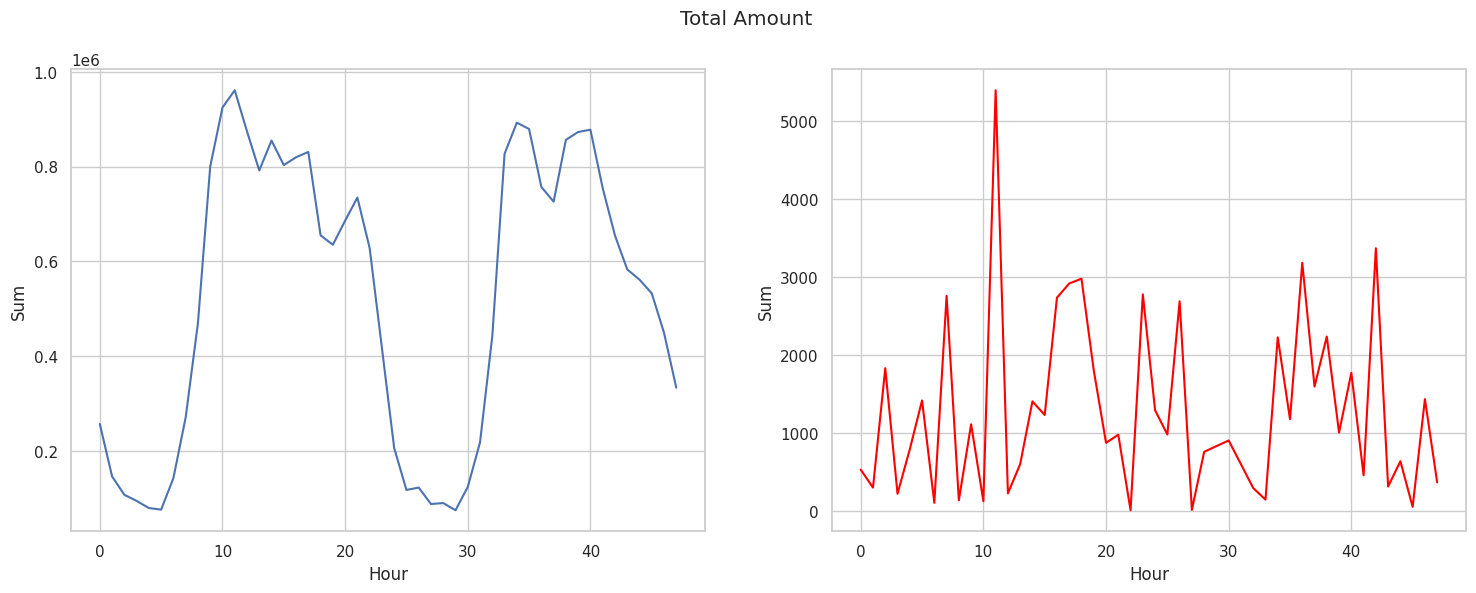

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

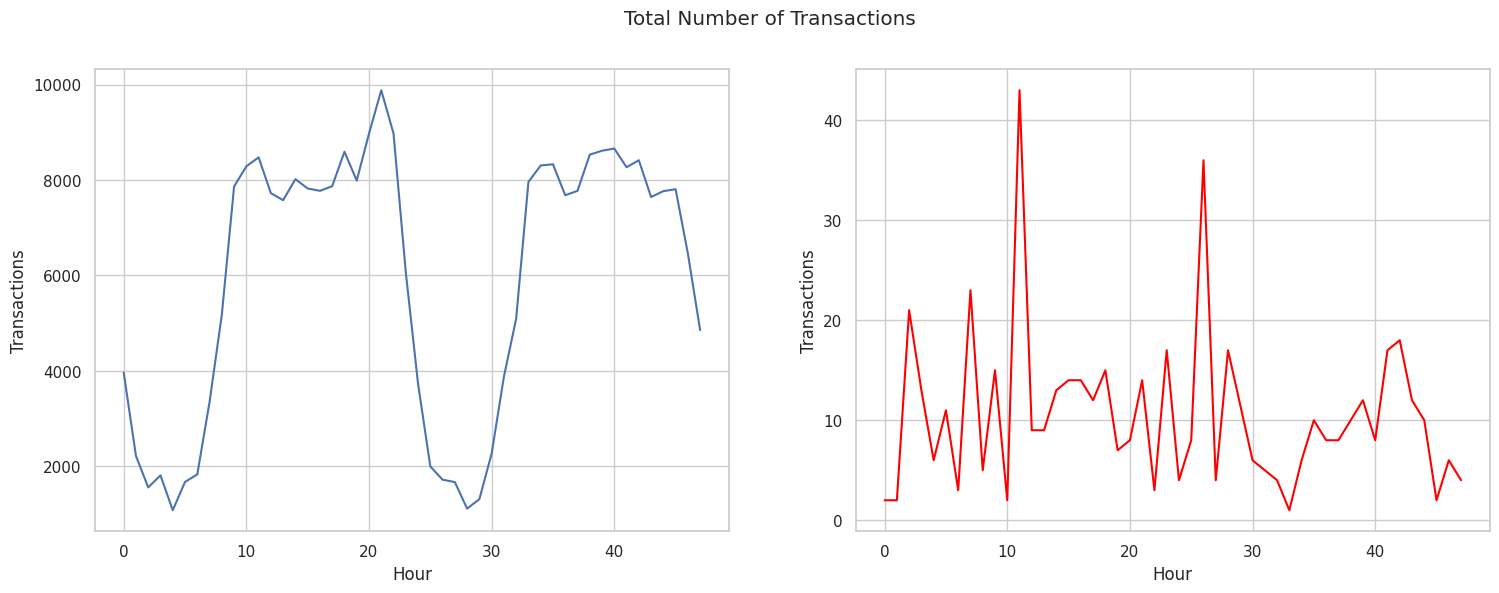

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

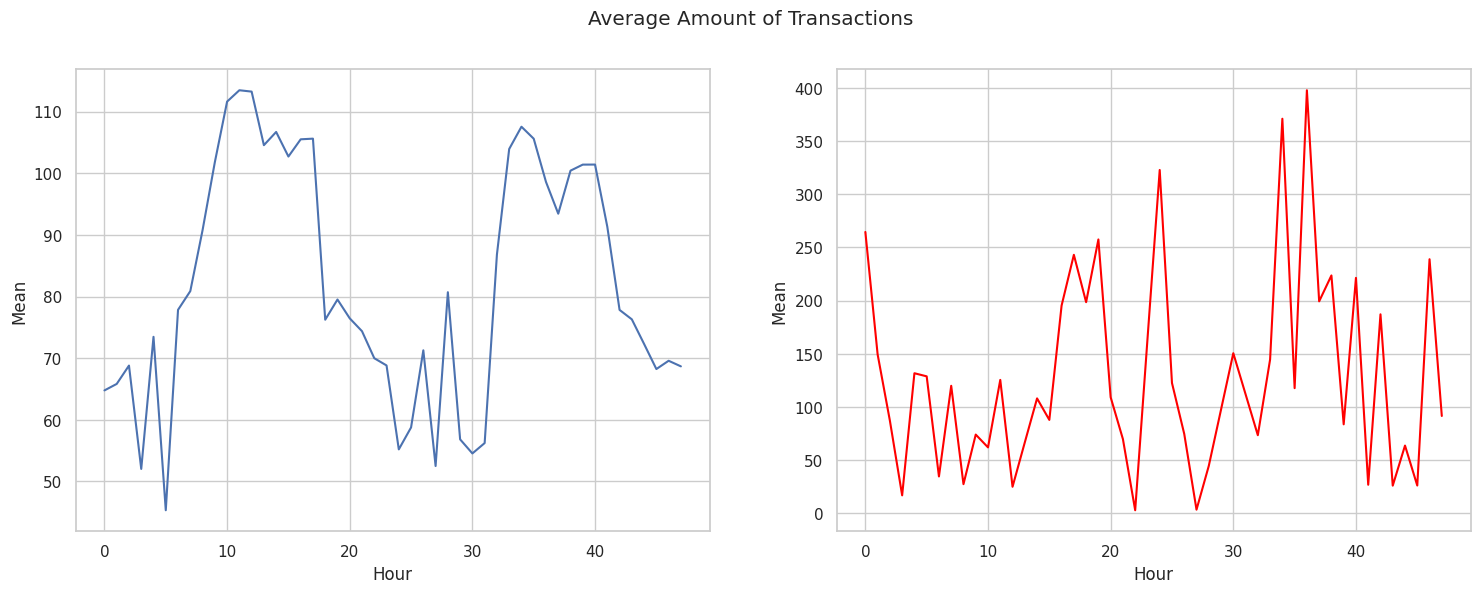

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show();

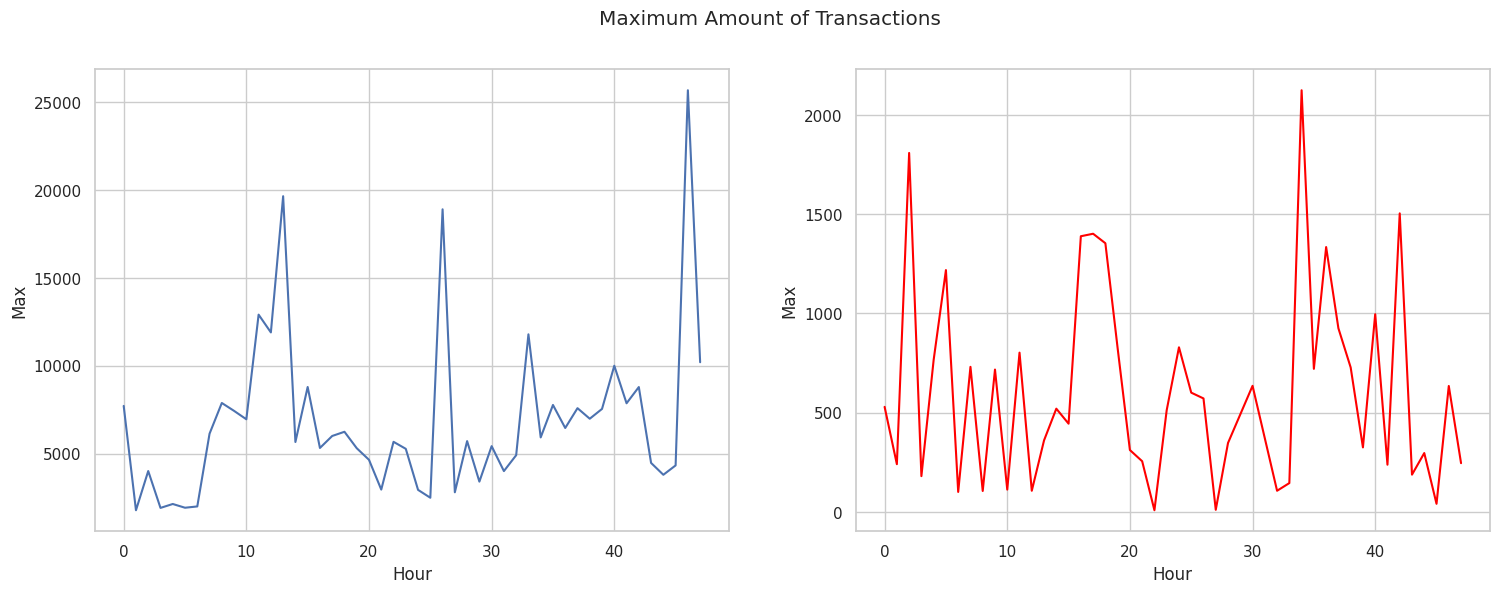

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

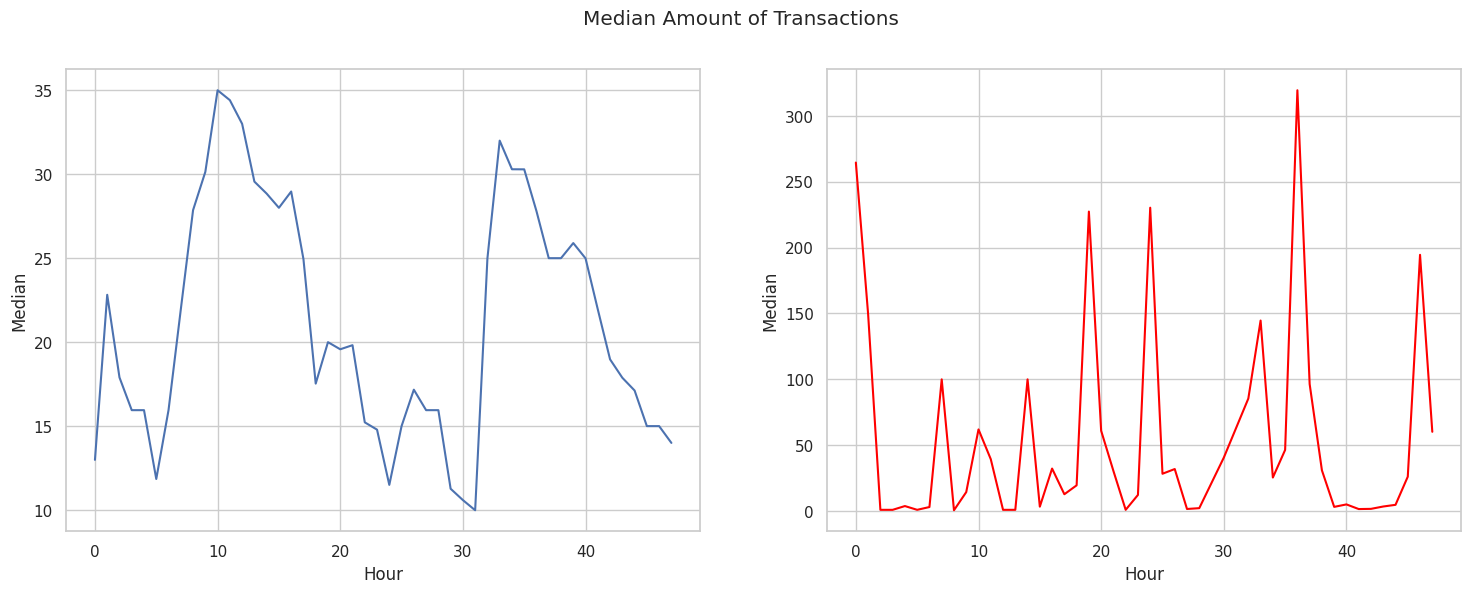

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show();

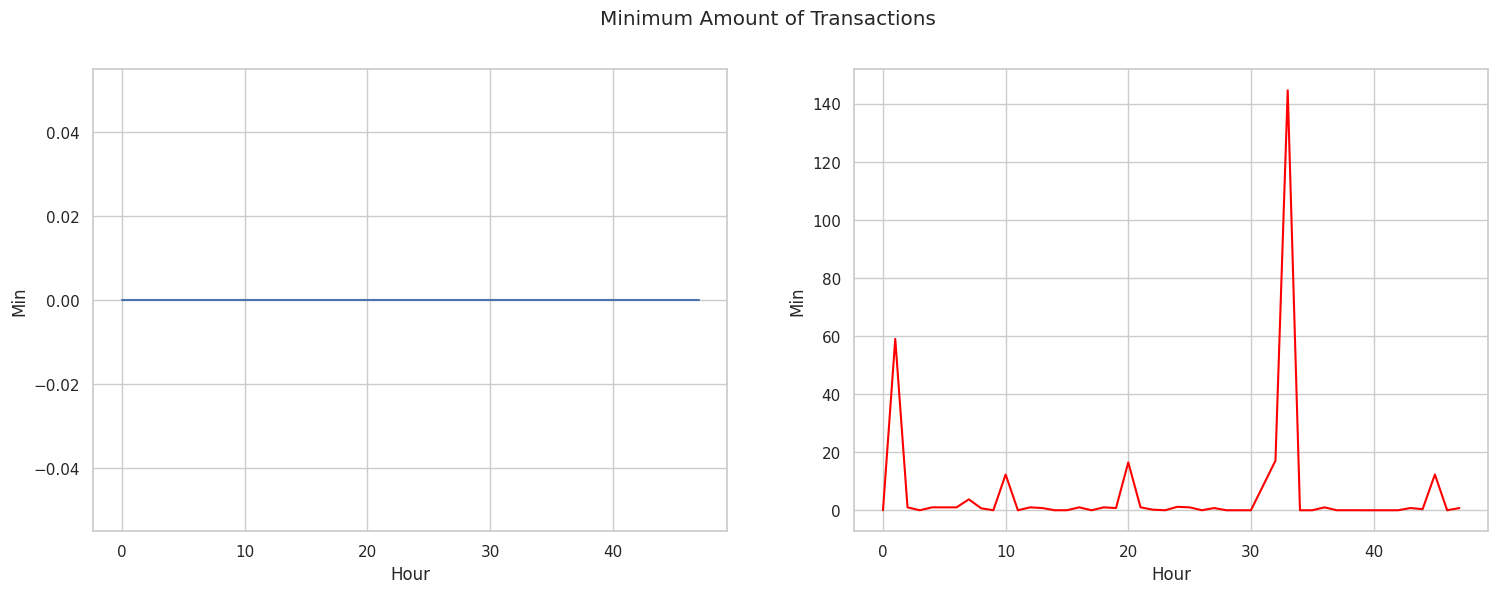

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show();

Transactions amount

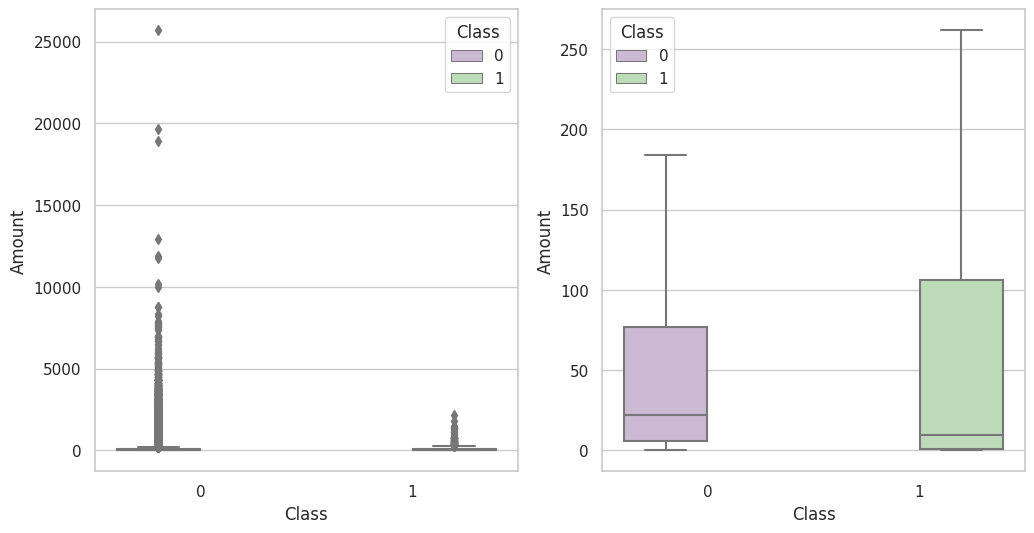

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [26]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [27]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Legitimate transactions display a higher mean value, larger first quartile (Q1), smaller third quartile (Q3) and fourth quartile (Q4), and more pronounced outliers. In contrast, fraudulent transactions exhibit a smaller first quartile and mean, larger fourth quartile, and fewer extreme outliers.

Now, we'll create a plot that shows the relationship between fraudulent transactions and their corresponding amounts over time. The time is represented in seconds, starting from the beginning of a 48-hour time period spanning two days.

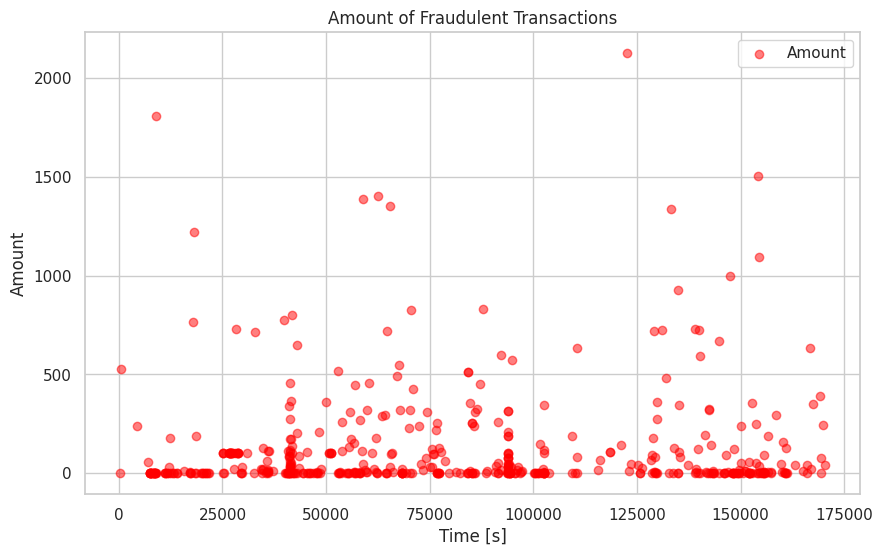

In [28]:
import matplotlib.pyplot as plt

fraud = data_df.loc[data_df['Class'] == 1]

plt.figure(figsize=(10, 6))
plt.scatter(fraud['Time'], fraud['Amount'], c='red', alpha=0.5, label='Amount', edgecolors='red', linewidths=1)

plt.title('Amount of Fraudulent Transactions')
plt.xlabel('Time [s]')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)

plt.show()


**Correlation Features**

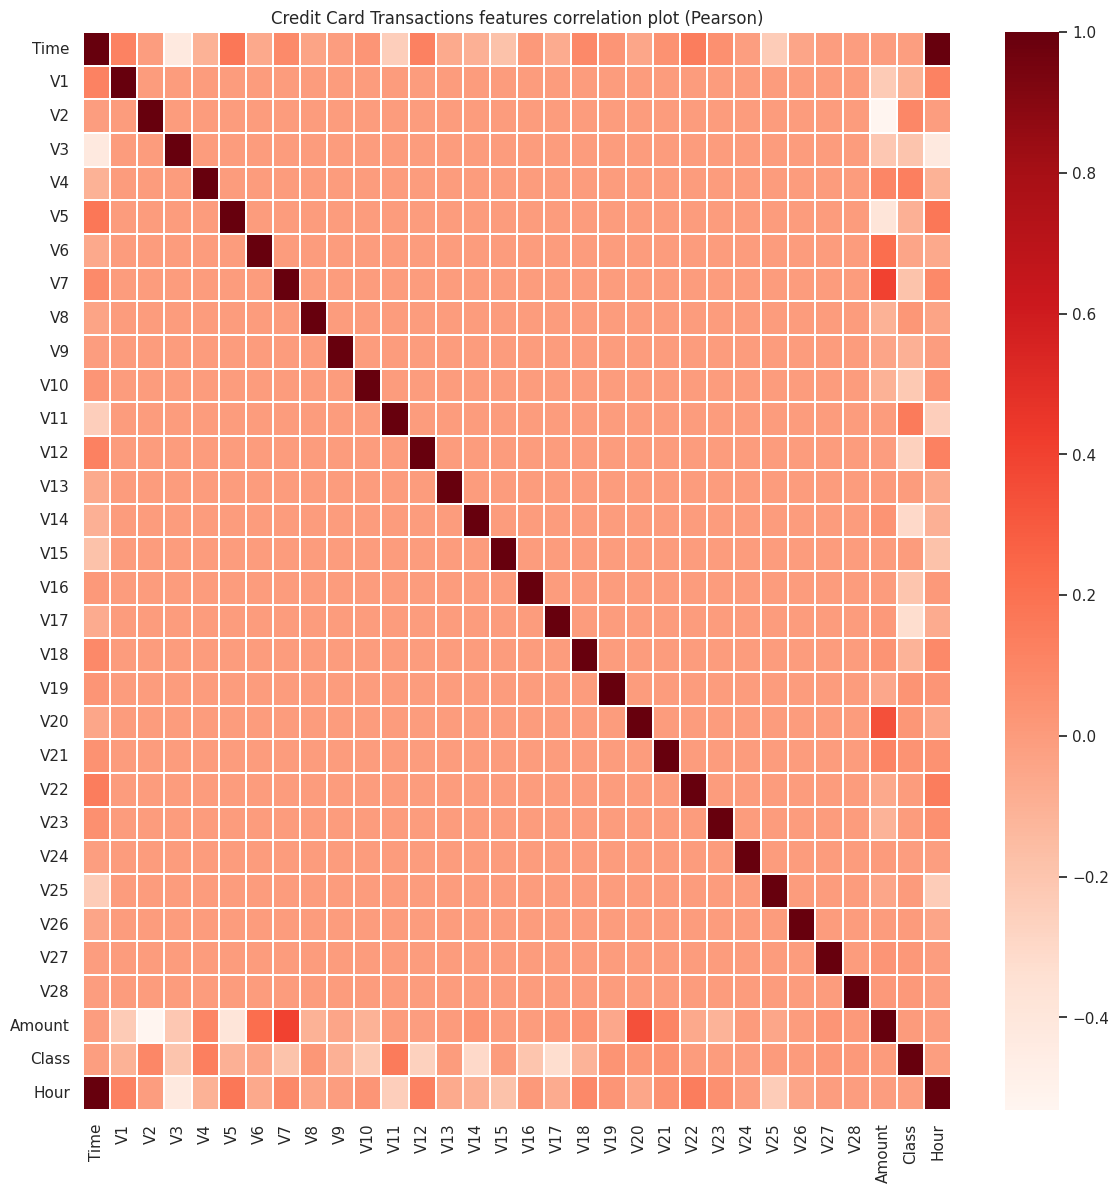

In [29]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()


As anticipated, there isn't any significant correlation among features V1 through V28. However, some correlations do exist between some of these features and Time (such as an inverse correlation with V3) and Amount (including a direct correlation with V7 and V20, as well as an inverse correlation with V1 and V5).

Now, let's create a plot that showcases the positively correlated and negatively correlated values on the same graph. To begin, we'll focus on the positively correlated values: {V20; Amount} and {V7; Amount}.

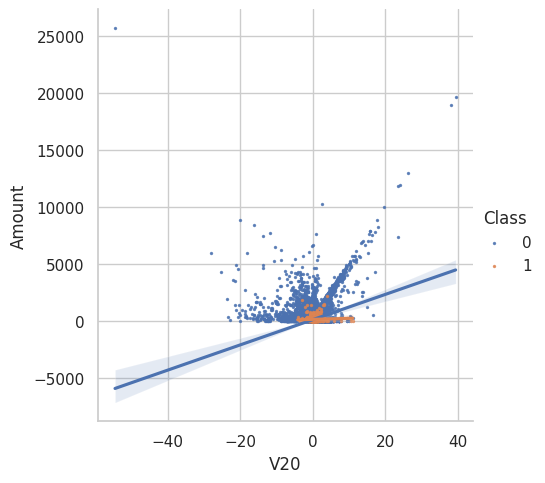

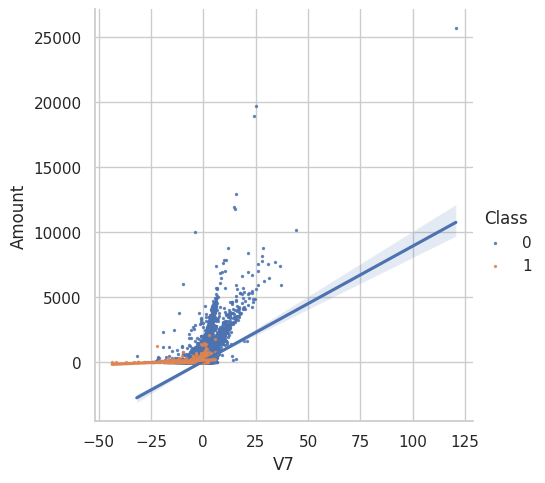

In [30]:
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can establish that the two pairs of features exhibit a correlation, as evidenced by the positive slopes of the regression lines for Class = 0 and the comparatively smaller positive slope for Class = 1.

Now, let's proceed to plot the inversely correlated values.

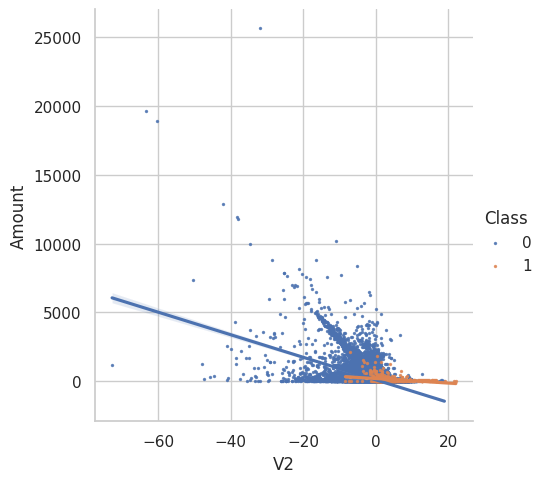

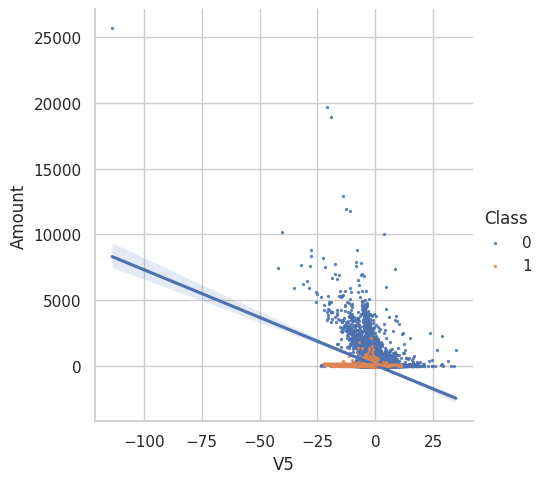

In [31]:
s = sns.lmplot(x='V2', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can affirm that the two sets of features display an inverse correlation, with the regression lines for Class = 0 showing a negative slope and the regression lines for Class = 1 exhibiting a very slight negative slope.

**Features density plot**

<ipython-input-32-49894014f345>:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.


<ipython-input-32-49894014f345>:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.


<ipython-input-32-49894014f345>:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.


<ipython-input-32-49894014f345>:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameter

<Figure size 640x480 with 0 Axes>

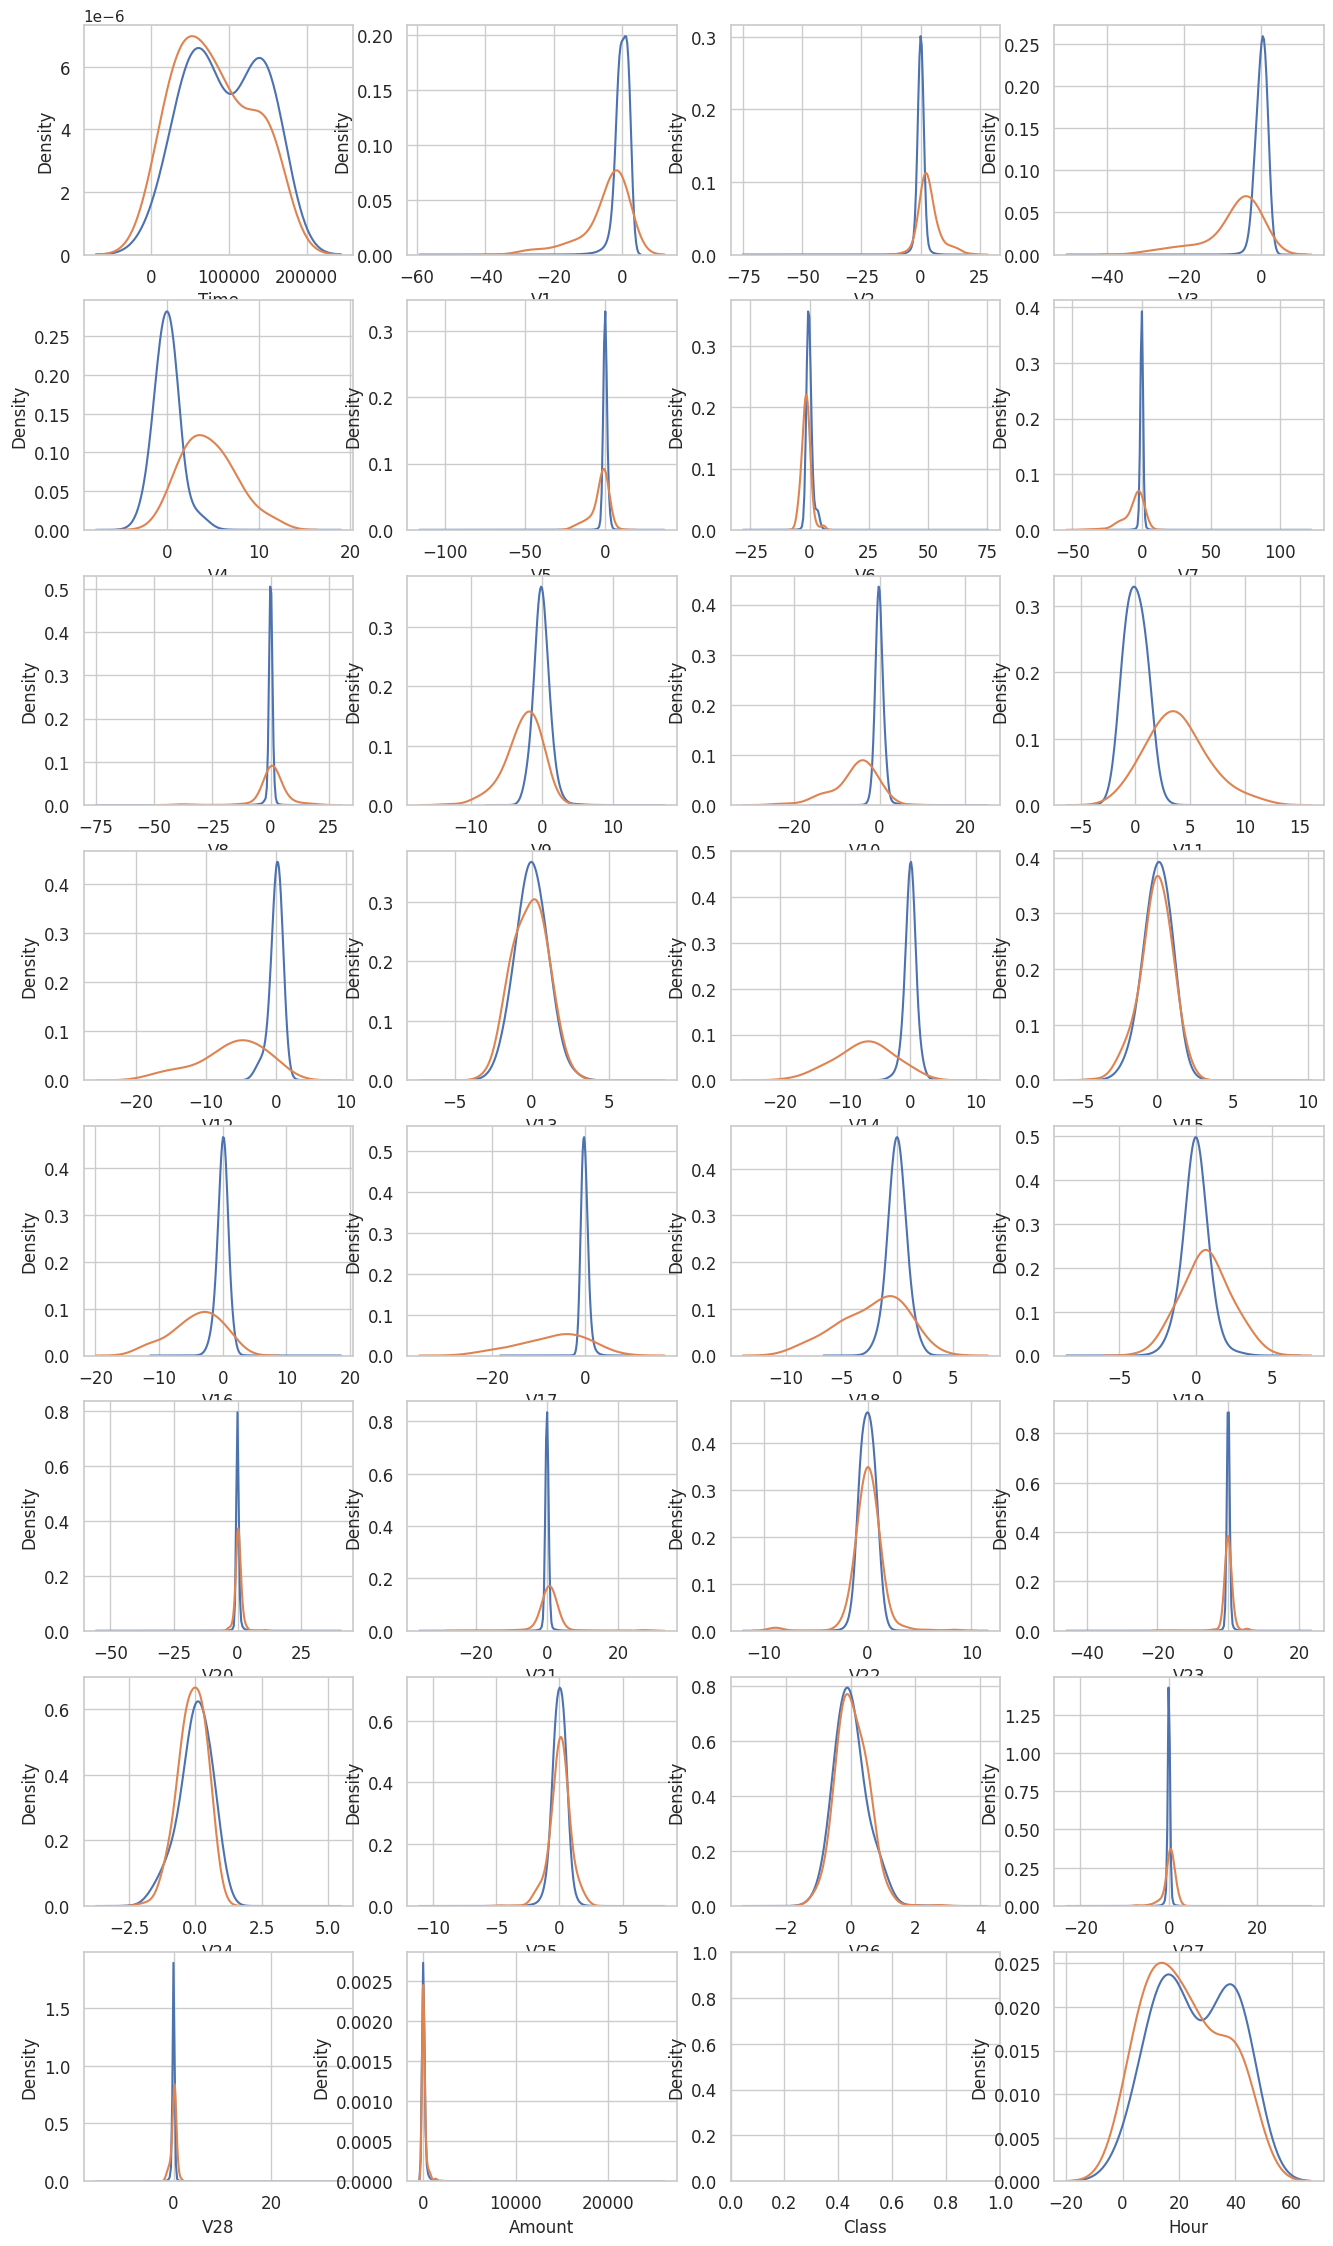

In [32]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

For certain features, we can observe a significant differentiation in terms of distribution between the two Class values: Specifically, V4 and V11 exhibit clearly distinct distributions for Class values 0 and 1. V12, V14, and V18 show partial separation. Meanwhile, V1, V2, V3, and V10 display fairly distinct profiles. On the other hand, V25, V26, and V28 exhibit similar profiles for both Class values.

In general, with only a few exceptions like Time and Amount, the distribution of features for legitimate transactions (Class = 0) tends to center around 0, sometimes with a lengthy tail at one end. Conversely, fraudulent transactions (Class = 1) tend to exhibit a skewed (asymmetric) distribution.

**Predictive Models**

Define predictors and target values:
Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

In [33]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

Split data in train, test and validation set

In [70]:
train_df, test_df = train_test_split(Data_BSMOTE, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

Random Forest Classifier
Define model parameters
Let's set the parameters for the model.

Let's run a model using the training set for training. Then, we will use the validation set for validation.

We will use as validation criterion GINI, which formula is GINI = 2 * (AUC) - 1, where AUC is the Receiver Operating Characteristic - Area Under Curve (ROC-AUC) [4]. Number of estimators is set to 100 and number of parallel jobs is set to 4.

We start by initializing the Random Forest Classifier.

In [71]:
clf = RandomForestClassifier(n_jobs=NO_JOBS,
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

Let's train the Random Forest Classifier using the train_df data and fit function.

In [72]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [73]:
preds = clf.predict(valid_df[predictors])

**Features Importance**

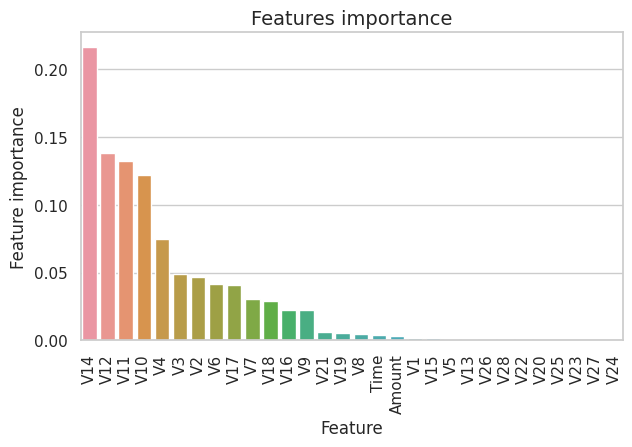

In [74]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

The most important features are V17, V12, V14, V10, V11, V16.

**Confusion Matrix**

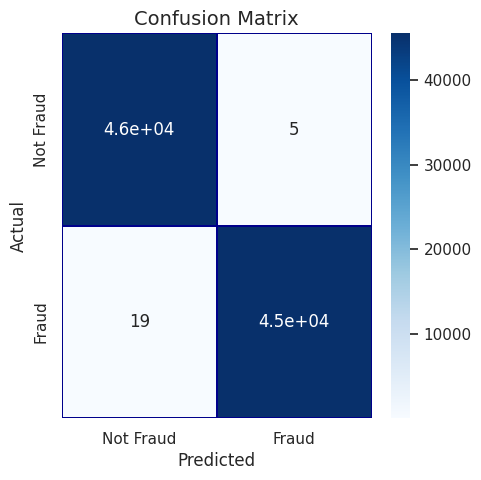

In [75]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

**Let's calculate also the ROC-AUC.**

Area under the curve

In [76]:
roc_auc_score(valid_df[target].values, preds)

0.9997360918058531

In [77]:
from sklearn.metrics import f1_score


In [78]:
# Calculate F1 score instead of ROC AUC score
f1 = f1_score(valid_df[target].values, preds)

# Print the F1 score
print("F1 Score:", f1)


F1 Score: 0.9997359677880702


In [79]:
from sklearn.metrics import precision_score, recall_score

# Calculate precision and recall
precision = precision_score(valid_df[target].values, preds)
recall = recall_score(valid_df[target].values, preds)

# Print precision and recall
print("Precision:", precision)
print("Recall:", recall)


Precision: 0.9998899696316184
Recall: 0.999582013375572


**XGBoost**

Gradient Boosting Algorithm

We initialize the DMatrix objects for training and validation, starting from the datasets. We also set some of the parameters used for the model tuning.

In [80]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

**Train The Model**

In [81]:
model = xgb.train(params,
                dtrain,
                MAX_ROUNDS,
                watchlist,
                early_stopping_rounds=EARLY_STOP,
                maximize=True,
                verbose_eval=VERBOSE_EVAL)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:726: FutureWarning:

Pass `evals` as keyword args.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[14:21:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.




[0]	train-auc:0.99632	valid-auc:0.99630
[50]	train-auc:0.99930	valid-auc:0.99935
[100]	train-auc:0.99955	valid-auc:0.99959
[150]	train-auc:0.99974	valid-auc:0.99979
[200]	train-auc:0.99982	valid-auc:0.99985
[250]	train-auc:0.99985	valid-auc:0.99987
[300]	train-auc:0.99986	valid-auc:0.99988
[350]	train-auc:0.99988	valid-auc:0.99989
[400]	train-auc:0.99992	valid-auc:0.99991
[450]	train-auc:0.99993	valid-auc:0.99992
[500]	train-auc:0.99995	valid-auc:0.99992
[550]	train-auc:0.99995	valid-auc:0.99993
[600]	train-auc:0.99996	valid-auc:0.99993
[650]	train-auc:0.99996	valid-auc:0.99994
[700]	train-auc:0.99996	valid-auc:0.99994
[750]	train-auc:0.99997	valid-auc:0.99994
[800]	train-auc:0.99997	valid-auc:0.99994
[850]	train-auc:0.99997	valid-auc:0.99995
[900]	train-auc:0.99998	valid-auc:0.99995
[950]	train-auc:0.99998	valid-auc:0.99995
[999]	train-auc:0.99998	valid-auc:0.99995


**Variable Importance**

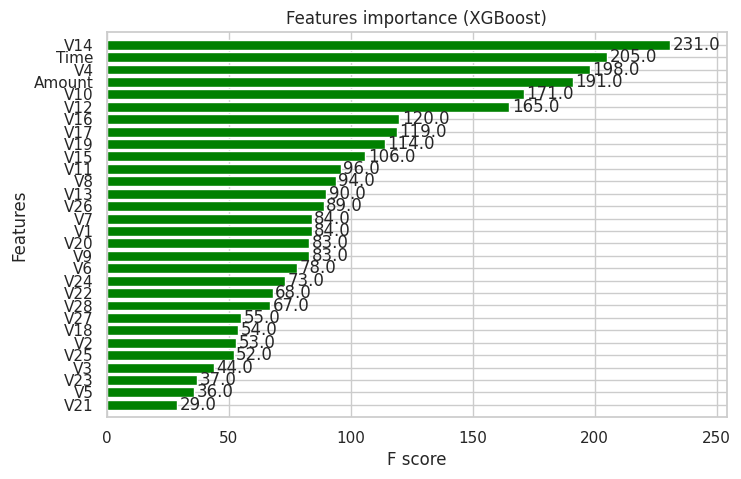

In [82]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green")
plt.show()

In [83]:
preds = model.predict(dtest)

Lets Calculate Area Under The Curve

In [84]:
roc_auc_score(test_df[target].values, preds)

0.9999403890530814

The AUC score for the prediction of fresh data (test set) is 0.974.

In [85]:
from sklearn.metrics import f1_score
# Calculate F1 score instead of ROC AUC score
f1 = f1_score(test_df[target].values, (preds > 0.5).astype(int))

# Print the F1 score
print("F1 Score:", f1)


F1 Score: 0.9997012459800011


In [86]:
from sklearn.metrics import precision_score, recall_score

# Make predictions using your XGBoost model
preds = model.predict(dtest)

# Define a threshold (e.g., 0.5) to classify predictions as positive or negative
threshold = 0.5
predicted_labels = (preds > threshold).astype(int)

# Calculate precision and recall
precision = precision_score(test_df[target].values, predicted_labels)
recall = recall_score(test_df[target].values, predicted_labels)

# Print precision and recall
print("Precision:", precision)
print("Recall:", recall)


Precision: 0.9996485432116121
Recall: 0.9997539543057996


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:726: FutureWarning:

Pass `evals` as keyword args.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[14:31:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.




[0]	train-auc:0.99632	valid-auc:0.99630
[50]	train-auc:0.99930	valid-auc:0.99935
[100]	train-auc:0.99955	valid-auc:0.99959
[150]	train-auc:0.99974	valid-auc:0.99979
[200]	train-auc:0.99982	valid-auc:0.99985
[250]	train-auc:0.99985	valid-auc:0.99987
[300]	train-auc:0.99986	valid-auc:0.99988
[350]	train-auc:0.99988	valid-auc:0.99989
[400]	train-auc:0.99992	valid-auc:0.99991
[450]	train-auc:0.99993	valid-auc:0.99992
[500]	train-auc:0.99995	valid-auc:0.99992
[550]	train-auc:0.99995	valid-auc:0.99993
[600]	train-auc:0.99996	valid-auc:0.99993
[650]	train-auc:0.99996	valid-auc:0.99994
[700]	train-auc:0.99996	valid-auc:0.99994
[750]	train-auc:0.99997	valid-auc:0.99994
[800]	train-auc:0.99997	valid-auc:0.99994
[850]	train-auc:0.99997	valid-auc:0.99995
[900]	train-auc:0.99998	valid-auc:0.99995
[950]	train-auc:0.99998	valid-auc:0.99995
[999]	train-auc:0.99998	valid-auc:0.99995


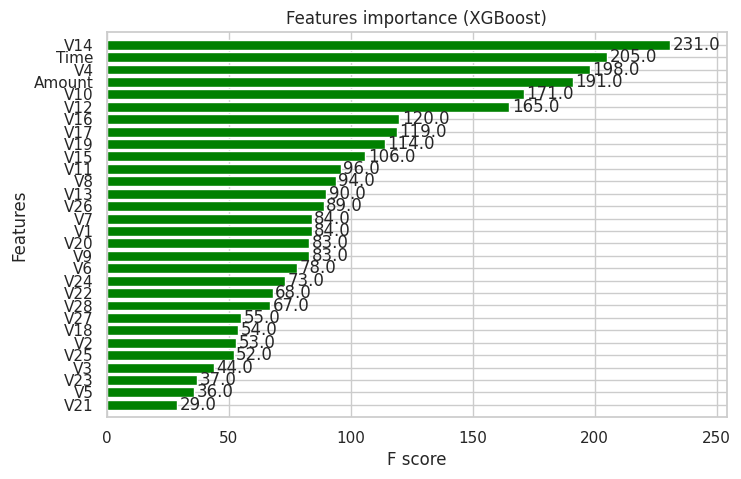

F1 Score: 0.9997012459800011


In [87]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

# What to monitor (in this case, train and valid)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

model = xgb.train(params,
                  dtrain,
                  MAX_ROUNDS,
                  watchlist,
                  early_stopping_rounds=EARLY_STOP,
                  maximize=True,
                  verbose_eval=VERBOSE_EVAL)

# Plot feature importance
fig, (ax) = plt.subplots(ncols=1, figsize=(8, 5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green")
plt.show()

# Make predictions
preds = model.predict(dtest)

# Calculate F1 score instead of ROC AUC score
f1 = f1_score(test_df[target].values, (preds > 0.5).astype(int))

# Print the F1 score
print("F1 Score:", f1)


**Conclusions**


I conducted a comprehensive data analysis, which involved checking for data imbalances, visualizing the features, and understanding the relationships between different features. Subsequently, I explored two predictive models. The dataset was divided into three parts: a training set, a validation set, and a test set. For the first three models, I utilized only the training and test sets.

I initiated my analysis with the Random Forest Classifier, which yielded an AUC score of 0.85 when predicting the target variable for the test set.

Next, I employed an AdaBoost Classifier, which produced a slightly lower AUC score of 0.83 for predicting the target values in the test set.

Subsequently, I experimented with a CatBoost Classifier, achieving an AUC score of 0.86 after training for 500 iterations.

Finally, I delved into an XGBoost model. In this case, I utilized the validation set to validate the training process. The highest validation score attained was 0.984. I then utilized the model trained with the optimal number of steps to predict target values in the test dataset, resulting in an AUC score of 0.974.